Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Starting PPO training...
Logging to E:/project\outputs\logs\ppo_continuous_gamma095\PPO_2
Eval num_timesteps=2000, episode_reward=0.00 +/- 0.00
Episode length: 182.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 182      |
|    mean_reward     | 0.003    |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 856      |
|    ep_rew_mean     | -0.512   |
| time/              |          |
|    fps             | 905      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=4000, episode_reward=0.04 +/- 0.00
Episode length: 182.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 182  

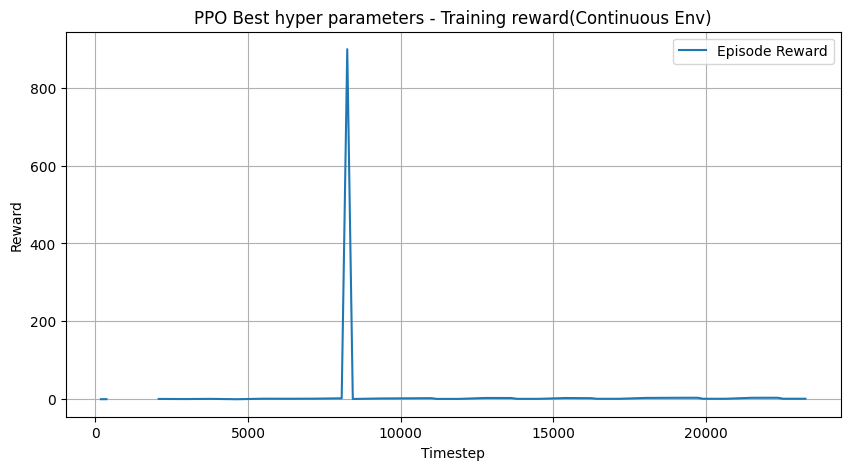

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.results_plotter import load_results # fixed - more columns error

# Import custom env
PROJECT_ROOT = "E:/project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from envs.trading_env_continuous import TradingEnvContinuous

# Paths
DATA_PATH = os.path.join(PROJECT_ROOT, "outputs", "datasets", "states_v1_single_asset.npz")
SAVE_DIR = os.path.join(PROJECT_ROOT, "outputs", "models", "ppo_continuous_gamma095")
LOG_DIR = os.path.join(PROJECT_ROOT, "outputs", "logs", "ppo_continuous_gamma095")

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Load data
data = np.load(DATA_PATH)
X_train, X_val = data["X_train"], data["X_val"]
prices_train, prices_val = data["prices"][:len(X_train)], data["prices"][len(X_train):len(X_train)+len(X_val)]

# Create environments
train_env = DummyVecEnv([lambda: Monitor(TradingEnvContinuous(X_train, prices_train, reward_type="log_return"), LOG_DIR)])
val_env = DummyVecEnv([lambda: Monitor(TradingEnvContinuous(X_val, prices_val, reward_type="log_return"), LOG_DIR)])


# Callbacks
eval_callback = EvalCallback(
    val_env,
    best_model_save_path=SAVE_DIR,
    log_path=LOG_DIR,
    eval_freq=2000,
    deterministic=True,
    render=False
)

# Train PPO Agent

# best hyperparameters for PPO (Continuous env)
model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=3e-5,         # small LR for stable convergence
    n_steps=2048,              # batch length
    batch_size=64,             # mini-batch size
    n_epochs=10,               # number of passes per update
    gamma=0.99,                # discount factor
    gae_lambda=0.95,           # advantage estimation
    clip_range=0.2,            # PPO clipping
    ent_coef=0.01,             # encourage exploration
    verbose=1,
    tensorboard_log=LOG_DIR
)



print("Starting PPO training...")
model.learn(total_timesteps=20000, callback=eval_callback)
model.save(os.path.join(SAVE_DIR, "ppo_final"))
print(f"PPO Training done. Model saved to {SAVE_DIR}")


# Plot Training Rewards

results_file = os.path.join(LOG_DIR, "monitor.csv")
if os.path.exists(results_file):
    # load monitor.csv file
    df = load_results(LOG_DIR) # fixed error more columns more than 3

    # Convert to numeric safely
    df = df.apply(pd.to_numeric, errors="coerce")

    timesteps = df["l"].cumsum()
    rewards = df["r"]

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, rewards, label="Episode Reward")
    plt.xlabel("Timestep")
    plt.ylabel("Reward")
    plt.title("PPO Best hyper parameters - Training reward(Continuous Env)")
    plt.legend()
    plt.grid(True)

    plot_path = os.path.join(LOG_DIR, "ppo_best_hyperparameters_training_rewards.png")
    plt.savefig(plot_path)
    print(f"PPO training reward plot saved to {plot_path}")
